# Проект: прогнозирование временных рядов

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Шаг 1. Подготовка

Загрузим наши данные, сразу сделав дату и время индексом. Изучим их:

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data.sort_index(inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


У нас есть 26496 записей за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00 за каждые 10 минут. 

Необходимо ресемплировать данные с промежутком в 1 час:

In [3]:
data = data.resample('1H').sum()
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Шаг 2. Анализ

Теперь проанализируем данные. Для начала изучим:

* Сам временной ряд
* Скользящее среднее
* Скользящее отклонение
* Разность временного ряда 

Для наглядности будем использовать не все данные, а только данные за последние 10 дней:

In [4]:
data_new = data['2018-08-22':'2018-09-01']
data_new['rolling_mean'] = data_new['num_orders'].rolling(30).mean()
data_new['rolling_std'] = data_new['num_orders'].rolling(30).std()
data_new['difference'] = data_new['num_orders'] - data_new['num_orders'].shift(1, fill_value=0)

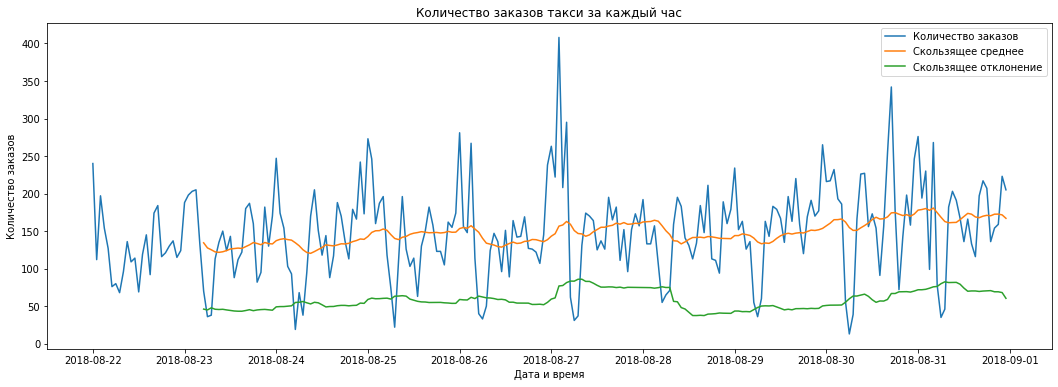

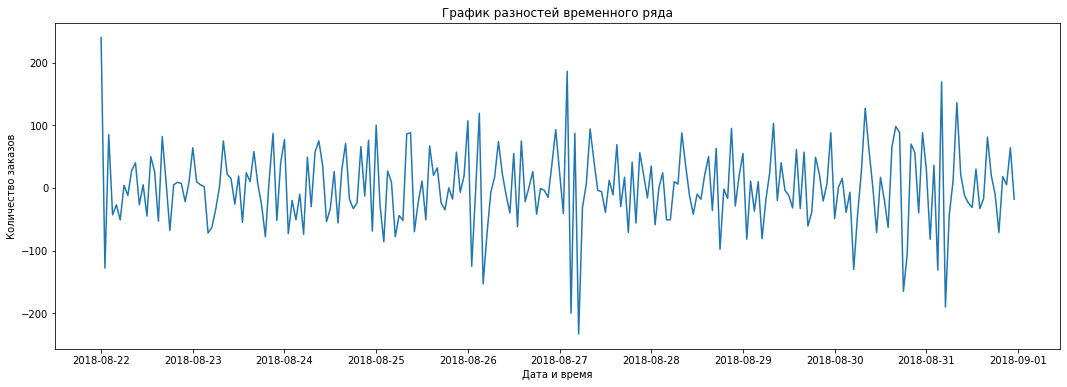

In [5]:
plt.figure(figsize=(18,6))
plt.title('Количество заказов такси за каждый час')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.plot(data_new['num_orders'], label='Количество заказов')
plt.plot(data_new['rolling_mean'], label='Скользящее среднее')
plt.plot(data_new['rolling_std'], label='Скользящее отклонение')
plt.legend()
plt.show()

plt.figure(figsize=(18,6))
plt.title('График разностей временного ряда')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.plot(data_new['difference'], label='num_orders')
plt.show()

Сам временной ряд не является стационарным: изменяется и среднее значение и стандартное отклонение.

А вот у разности временного ряда уже наблюдается постоянство среднего значения, хотя и меняется стандартное отклонение, и ряд не является стационарным.

Теперь изучим тренд и сезонность. Для тренда возьмем все выборку, а для сезонности сокращенную:

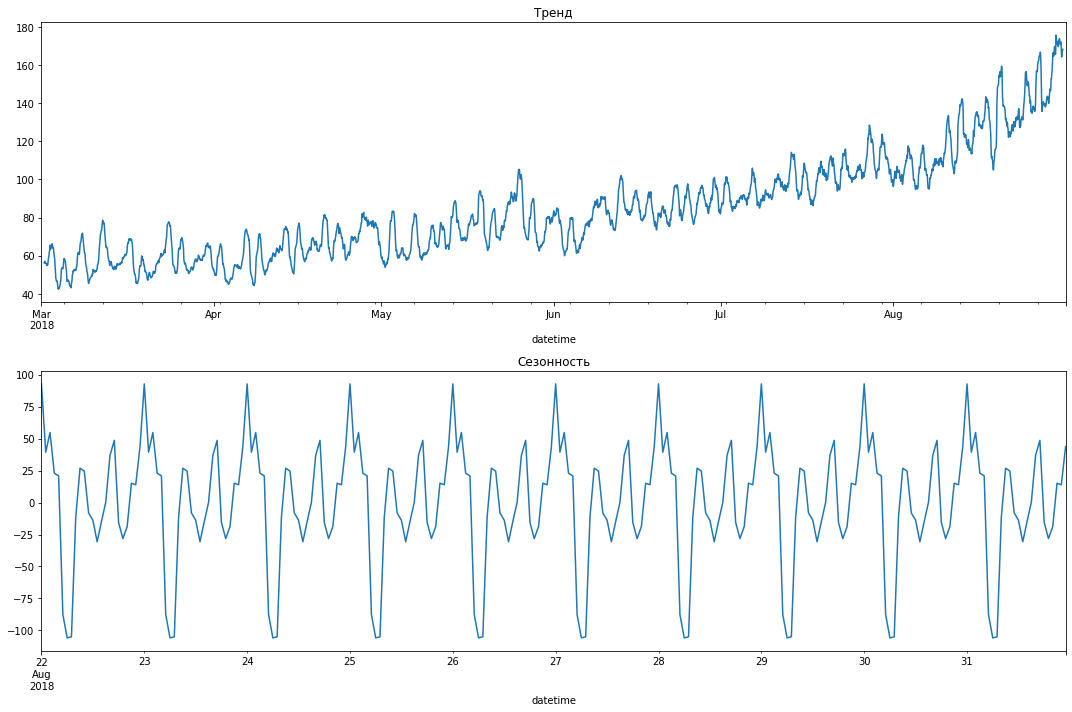

In [6]:
decomposed = seasonal_decompose(data['num_orders'])
decomposed_short = seasonal_decompose(data_new['num_orders'])
plt.figure(figsize=(15, 10))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(212)
decomposed_short.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.tight_layout()

Линия тренда показывает постепенное возрастание количества заказов, сезонность показывает наличие ежедневных циклов количества заказов.

# Шаг 3. Обучение

Теперь займемся формированием признаков и подбором модели. Для начала сформируем признаки из самой даты: месяц, день и час. 

Также напишем функцию, которая будет добавлять определенное количество признаков-лагов и скользящее среднее с определенной шириной окна.

In [7]:
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

def make_features(data, max_lag, rolling_mean_size):
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data
    

Теперь напишем код, который будет перебирать параметры выборки для метода make_features(), а затем для каждого набора этих параметров подбирать гиперпараметры моделей и записывать лучшие результаты в отдельную сводную таблицу stats, по которой и будет вынесено решение о лучшей модели.

Будем использовать модели и гиперпараметры:

* Решающее дерево(глубина)
* Случаный лес(глубина и количество деревьев)
* Линейную регрессию
* Градиентный бустинг CatBoost(возьмем с дефолтными параметрами)

*Внимание, ячейка работает долго*

In [8]:
%%time

tree_score = 1000
tree_depth = 0
forest_score = 1000
forest_depth = 0
forest_est = 0

stats = pd.DataFrame(columns=['lags','rolling_mean_size','model','RMSE_score','params'])

data_loop = data.copy()

for max_lag in np.arange(10,31,5):
    for rolling_mean_size in np.arange(10,31,10):
        data_loop = make_features(data_loop, max_lag, rolling_mean_size)                    #готовим признаки
        data_loop.dropna(inplace=True)
        train_valid, test = train_test_split(data_loop, shuffle=False, test_size=0.1)
        train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)     #делим выборку
        X_train = train.drop(['num_orders'],axis=1)
        Y_train = train['num_orders']
        X_valid = valid.drop(['num_orders'],axis=1)
        Y_valid = valid['num_orders']
        for max_depth in [3,6,9,12]:                                                   #перебираем модели
            tree = DecisionTreeRegressor(max_depth = max_depth, random_state=1757)
            tree.fit(X_train, Y_train)
            prediction = tree.predict(X_valid)
            score = mean_squared_error(prediction, Y_valid)**0.5
            if score < tree_score:
                tree_score = score
                tree_depth = max_depth
        stats.loc[len(stats)] = [max_lag,rolling_mean_size,'DesicionTreeRegressor',tree_score,tree_depth] #записываем результат
        for max_depth in [9,12,15]:
            for n_est in[100,150,200]:
                forest = RandomForestRegressor(max_depth = max_depth, n_estimators=n_est, random_state=1757)
                forest.fit(X_train, Y_train)
                prediction = forest.predict(X_valid)
                score = mean_squared_error(prediction, Y_valid)**0.5
                if score < tree_score:
                    forest_score = score
                    forest_depth = max_depth
                    forest_est = n_est
        stats.loc[len(stats)] = [max_lag,rolling_mean_size,'RandomForestRegressor',forest_score,[forest_depth,n_est]]
        lr = LinearRegression()
        lr.fit(X_train, Y_train)
        prediction = lr.predict(X_valid)
        score = mean_squared_error(prediction, Y_valid)**0.5
        stats.loc[len(stats)] = [max_lag,rolling_mean_size,'LinearRegression',score,'-']
        cat = CatBoostRegressor()
        cat.fit(X_train, Y_train, verbose=False)
        prediction = cat.predict(X_valid)
        score = mean_squared_error(prediction, Y_valid)**0.5 
        stats.loc[len(stats)] = [max_lag,rolling_mean_size,'CatBoost',score,"-"]

stats = stats.sort_values(by='RMSE_score')
stats

CPU times: user 21min 52s, sys: 1min 4s, total: 22min 57s
Wall time: 23min 22s


,lags,rolling_mean_size,model,RMSE_score,params
51,30,10,CatBoost,30.654390,-
55,30,20,CatBoost,30.741804,-
47,25,30,CatBoost,30.835350,-
15,15,10,CatBoost,31.123705,-
9,10,30,RandomForestRegressor,31.281682,"[15, 200]"
19,15,20,CatBoost,31.293939,-
39,25,10,CatBoost,31.362642,-
17,15,20,RandomForestRegressor,31.418521,"[15, 200]"
5,10,20,RandomForestRegressor,31.528868,"[15, 200]"
1,10,10,RandomForestRegressor,31.534231,"[15, 200]"


Как видим по сводной таблице, лучший результат показывает CatBoost "из коробки" при параметрах выборки max_lag=30 и rolling_mean_size=10.

# Шаг 4. Тестирование

Теперь обучим выбранную нами модель и проверим её качество на тестовой выборке:

In [9]:
data = make_features(data,30,10)                    
data.dropna(inplace=True)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
X_train = train.drop(['num_orders'],axis=1)
Y_train = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
Y_test = test['num_orders']

model = CatBoostRegressor(random_state=1757)
model.fit(X_train, Y_train, verbose=False)
prediction = model.predict(X_test)
rmse = mean_squared_error(prediction, Y_test)**0.5 
rmse

40.566646199477105

## Вывод

В итоге нам удалось достичь результата RMSE=40.57 на тестовой выборке. Этот результат достигается за счет модели CatBoostRegressor на дефолтных параметрах. При этом в качестве признаков используются: месяц, день, час, 30 признаков-лагов и скользящее среднее с окном в 10.